# Scorecard bins using woebin() 

ChiMerge (Chi-Square-based binning) — default in most implementations

1. It starts by treating every unique value as its own bin.
2. Then, it iteratively merges adjacent bins that have similar default rates using the Chi-square test of independence.
3. The goal: find bins that are statistically different in terms of default behavior.

It stops merging when:
* The Chi-square statistic exceeds a threshold (significant difference), or
* The maximum number of bins is reached, or
* Merging no longer improves monotonicity.

✅ Result:
You get bins that separate good vs bad customers most distinctly, which leads to better Weight of Evidence (WOE) transformation.

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import warnings

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
import scorecardpy as sc
import pprint

c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
DATA_PATH = Path("merged_applicant_and_bureau_cleaned_2.csv")   
df = pd.read_csv(DATA_PATH)
df

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO,YEARS_EMPLOYED
0,0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.254795
1,1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.616438
2,2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.326027
3,3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.323288
4,4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.350685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254353,254353,456248,0,Working,Separated,0,153000.0,331920.0,16096.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.884932
254354,254354,456252,0,Pensioner,Widow,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254355,254355,456253,0,Working,Separated,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.701370
254356,254356,456254,1,Commercial associate,Married,0,171000.0,370107.0,20205.0,319500.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.112329


In [3]:
df = df[[
    "TARGET",
    "DEBT_RATIO",
    "AMT_ANNUITY",
    "NAME_INCOME_TYPE",
    "AMT_CREDIT",
    "AGE",
    "OCCUPATION_TYPE",
    "AMT_CREDIT_SUM_DEBT_sum",
    "YEARS_EMPLOYED"
]]
df

,TARGET,DEBT_RATIO,AMT_ANNUITY,NAME_INCOME_TYPE,AMT_CREDIT,AGE,OCCUPATION_TYPE,AMT_CREDIT_SUM_DEBT_sum,YEARS_EMPLOYED
0,0,0.0,35698.5,State servant,1293502.5,45.931507,Core staff,0.0,3.254795
1,0,NaN,6750.0,Working,135000.0,52.180822,Laborers,NaN,0.616438
2,0,NaN,29686.5,Working,312682.5,52.068493,Laborers,NaN,8.326027
3,0,NaN,21865.5,Working,513000.0,54.608219,Core staff,NaN,8.323288
4,0,NaN,27517.5,State servant,490495.5,46.413699,Laborers,NaN,4.350685
...,...,...,...,...,...,...,...,...,...
254353,0,NaN,16096.5,Working,331920.0,45.767123,Sales staff,NaN,19.884932
254354,0,NaN,12001.5,Pensioner,269550.0,56.917808,NaN,NaN,NaN
254355,0,NaN,29979.0,Working,677664.0,41.002740,Managers,NaN,21.701370
254356,1,0.0,20205.0,Commercial associate,370107.0,32.769863,Laborers,0.0,13.112329


In [4]:
df.isnull().sum()


TARGET                         0
DEBT_RATIO                 98302
AMT_ANNUITY                    9
NAME_INCOME_TYPE               0
AMT_CREDIT                     0
AGE                            0
OCCUPATION_TYPE            81149
AMT_CREDIT_SUM_DEBT_sum    98302
YEARS_EMPLOYED             47945
dtype: int64

In [5]:
# Fill numeric columns with 0
df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
df['AMT_CREDIT_SUM_DEBT_sum'] = df['AMT_CREDIT_SUM_DEBT_sum'].fillna(0)
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(0)

# Fill OCCUPATION_TYPE with 'MISSING'
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('MISSING')

# Verify no missing values remain
print(df.isnull().sum())

TARGET                     0
DEBT_RATIO                 0
AMT_ANNUITY                0
NAME_INCOME_TYPE           0
AMT_CREDIT                 0
AGE                        0
OCCUPATION_TYPE            0
AMT_CREDIT_SUM_DEBT_sum    0
YEARS_EMPLOYED             0
dtype: int64


C:\Users\johnt\AppData\Local\Temp\ipykernel_40336\3745332102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEBT_RATIO'] = df['DEBT_RATIO'].fillna(0)
C:\Users\johnt\AppData\Local\Temp\ipykernel_40336\3745332102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(0)
C:\Users\johnt\AppData\Local\Temp\ipykernel_40336\3745332102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [6]:
train, test = sc.split_df(df, y = 'TARGET', ratio = .7).values()
print(train.shape)
print(test.shape)

(178050, 9)
(76308, 9)


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\split_df.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=ratio[0], random_state=seed))\


In [7]:
# automatically calculate bin ranges, bins is a dictionary
bins = sc.woebin(train, y = 'TARGET')

for variables, bindetails in bins.items():
    print(variables, " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\condition_fun.py:40: UserWarning: Could not infer fo

NAME_INCOME_TYPE  : 


c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'good':sum, 'bad':sum}).reset_index()\
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'good':sum, 'bad':sum}).reset_index()\
c:\Users\johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\scorecardpy\woebin.py:425: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the group

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Businessman%,%Student%,%State servant",12850,0.072171,12173,677,0.052685,-0.393100,0.009455,0.047357,"Businessman%,%Student%,%State servant",False
1,NAME_INCOME_TYPE,Pensioner,33585,0.188627,31707,1878,0.055918,-0.330126,0.017891,0.047357,Pensioner,False
2,NAME_INCOME_TYPE,Commercial associate,40595,0.227998,37771,2824,0.069565,-0.097183,0.002067,0.047357,Commercial associate,False
3,NAME_INCOME_TYPE,"Working%,%Unemployed%,%Maternity leave",91020,0.511205,82845,8175,0.089815,0.180314,0.017944,0.047357,"Working%,%Unemployed%,%Maternity leave",False


----------------------------------------------------------------------------------------------------
DEBT_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_RATIO,"[-inf,0.22)",162870,0.914743,151244,11626,0.071382,-0.069446,0.004284,0.039354,0.22,False
1,DEBT_RATIO,"[0.22,inf)",15180,0.085257,13252,1928,0.127009,0.568539,0.035070,0.039354,inf,False


----------------------------------------------------------------------------------------------------
OCCUPATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,"Accountants%,%HR staff%,%Core staff",20708,0.116304,19629,1079,0.052105,-0.404769,0.016078,0.070432,"Accountants%,%HR staff%,%Core staff",False
1,OCCUPATION_TYPE,"Secretaries%,%Managers%,%High skill tech staff...",84214,0.472980,78921,5293,0.062852,-0.205858,0.018375,0.070432,"Secretaries%,%Managers%,%High skill tech staff...",False
2,OCCUPATION_TYPE,"Sales staff%,%Cooking staff%,%Realty agents%,%...",73128,0.410716,65946,7182,0.098211,0.278946,0.035979,0.070432,"Sales staff%,%Cooking staff%,%Realty agents%,%...",False


----------------------------------------------------------------------------------------------------
AMT_CREDIT_SUM_DEBT_sum  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_DEBT_sum,"[-inf,8000.0)",156394,0.878371,145323,11071,0.070789,-0.078425,0.005226,0.037623,8000.0,False
1,AMT_CREDIT_SUM_DEBT_sum,"[8000.0,44000.0)",11843,0.066515,10620,1223,0.103268,0.334772,0.008594,0.037623,44000.0,False
2,AMT_CREDIT_SUM_DEBT_sum,"[44000.0,inf)",9813,0.055114,8553,1260,0.128401,0.581034,0.023803,0.037623,inf,False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,0.5)",38526,0.216377,36153,2373,0.061595,-0.227400,0.010165,0.083439,0.5,False
1,YEARS_EMPLOYED,"[0.5,4.0)",53333,0.299539,47813,5520,0.103501,0.337285,0.039326,0.083439,4.0,False
2,YEARS_EMPLOYED,"[4.0,8.5)",41802,0.234777,38520,3282,0.078513,0.033480,0.000267,0.083439,8.5,False
3,YEARS_EMPLOYED,"[8.5,15.0)",28141,0.158051,26493,1648,0.058562,-0.281114,0.011095,0.083439,15.0,False
4,YEARS_EMPLOYED,"[15.0,inf)",16248,0.091255,15517,731,0.044990,-0.559073,0.022586,0.083439,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,16000.0)",37920,0.212974,35364,2556,0.067405,-0.131046,0.003460,0.022366,16000.0,False
1,AMT_ANNUITY,"[16000.0,36000.0)",97105,0.545381,88908,8197,0.084414,0.112371,0.007223,0.022366,36000.0,False
2,AMT_ANNUITY,"[36000.0,44000.0)",20466,0.114945,18933,1533,0.074905,-0.017475,0.000035,0.022366,44000.0,False
3,AMT_ANNUITY,"[44000.0,inf)",22559,0.126700,21291,1268,0.056208,-0.324639,0.011648,0.022366,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,150000.0)",9684,0.054389,9137,547,0.056485,-0.319434,0.004852,0.048077,150000.0,False
1,AMT_CREDIT,"[150000.0,300000.0)",36321,0.203993,33590,2731,0.075191,-0.013356,0.000036,0.048077,300000.0,False
2,AMT_CREDIT,"[300000.0,650000.0)",59434,0.333805,53862,5572,0.093751,0.227533,0.019035,0.048077,650000.0,False
3,AMT_CREDIT,"[650000.0,1100000.0)",49028,0.275361,45543,3485,0.071082,-0.073984,0.001461,0.048077,1100000.0,False
4,AMT_CREDIT,"[1100000.0,1350000.0)",13075,0.073434,12297,778,0.059503,-0.264180,0.004585,0.048077,1350000.0,False
5,AMT_CREDIT,"[1350000.0,inf)",10508,0.059017,10067,441,0.041968,-0.631769,0.018108,0.048077,inf,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,39.0)",51545,0.289497,46523,5022,0.097429,0.270086,0.023686,0.054217,39.0,False
1,AGE,"[39.0,53.0)",73605,0.413395,68015,5590,0.075946,-0.002544,0.000003,0.054217,53.0,False
2,AGE,"[53.0,57.0)",19916,0.111856,18708,1208,0.060655,-0.243781,0.005998,0.054217,57.0,False
3,AGE,"[57.0,inf)",32984,0.185251,31250,1734,0.052571,-0.395384,0.024530,0.054217,inf,False


----------------------------------------------------------------------------------------------------


In [8]:
# sample code

# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,TARGET,NAME_INCOME_TYPE_woe,DEBT_RATIO_woe,OCCUPATION_TYPE_woe,AMT_CREDIT_SUM_DEBT_sum_woe,YEARS_EMPLOYED_woe,AMT_ANNUITY_woe,AMT_CREDIT_woe,AGE_woe
0,0,-0.393100,-0.069446,-0.404769,-0.078425,0.337285,0.112371,-0.264180,-0.002544
1,0,0.180314,-0.069446,0.278946,-0.078425,0.337285,-0.131046,-0.319434,-0.002544
3,0,0.180314,-0.069446,-0.404769,-0.078425,0.033480,0.112371,0.227533,-0.243781
5,0,-0.097183,-0.069446,-0.404769,-0.078425,-0.281114,-0.017475,-0.631769,0.270086
6,0,-0.393100,-0.069446,-0.205858,-0.078425,0.337285,-0.017475,-0.631769,-0.002544
...,...,...,...,...,...,...,...,...,...
254350,0,-0.097183,-0.069446,0.278946,-0.078425,0.337285,-0.131046,-0.013356,0.270086
254352,0,-0.097183,-0.069446,-0.404769,-0.078425,0.337285,0.112371,0.227533,0.270086
254353,0,0.180314,-0.069446,0.278946,-0.078425,-0.559073,0.112371,0.227533,-0.002544
254354,0,-0.330126,-0.069446,-0.205858,-0.078425,-0.227400,-0.131046,-0.013356,-0.243781


In [9]:
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

#THIS NOT THE RIGHT THING TO DO I THINK 
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# create a logistic regression model object
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),
          index = np.concatenate([['intercept'], lr.feature_names_in_]) )

intercept                      0.000191
NAME_INCOME_TYPE_woe           0.207906
DEBT_RATIO_woe                 0.503765
OCCUPATION_TYPE_woe            0.632237
AMT_CREDIT_SUM_DEBT_sum_woe    0.481662
YEARS_EMPLOYED_woe             0.667851
AMT_ANNUITY_woe                0.374661
AMT_CREDIT_woe                 0.721971
AGE_woe                        0.442443
dtype: float64

In [10]:
# sample code

# generate a card from the model and bins. The scores will be based on probability of default from the model
# bins = bins created from sc.woebin
# lr = fitted logistic regression model
# align target odds with probabity of default = 7.6% 
# odds = p/(1-p) = 0.076/(1-0.076) = 0.0825 ~= 1/12
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/12, pdo = 20, basepoints_eq0 = True)

pprint.pprint(card)

{'AGE':    variable          bin  points
27      AGE  [-inf,39.0)    63.0
28      AGE  [39.0,53.0)    66.0
29      AGE  [53.0,57.0)    69.0
30      AGE   [57.0,inf)    71.0,
 'AMT_ANNUITY':        variable                bin  points
17  AMT_ANNUITY     [-inf,16000.0)    67.0
18  AMT_ANNUITY  [16000.0,36000.0)    65.0
19  AMT_ANNUITY  [36000.0,44000.0)    66.0
20  AMT_ANNUITY      [44000.0,inf)    70.0,
 'AMT_CREDIT':       variable                    bin  points
21  AMT_CREDIT        [-inf,150000.0)    73.0
22  AMT_CREDIT    [150000.0,300000.0)    66.0
23  AMT_CREDIT    [300000.0,650000.0)    61.0
24  AMT_CREDIT   [650000.0,1100000.0)    68.0
25  AMT_CREDIT  [1100000.0,1350000.0)    72.0
26  AMT_CREDIT        [1350000.0,inf)    79.0,
 'AMT_CREDIT_SUM_DEBT_sum':                    variable               bin  points
9   AMT_CREDIT_SUM_DEBT_sum     [-inf,8000.0)    67.0
10  AMT_CREDIT_SUM_DEBT_sum  [8000.0,44000.0)    61.0
11  AMT_CREDIT_SUM_DEBT_sum     [44000.0,inf)    58.0,
 'DEBT_RATI

In [11]:
# sample code

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

# sample code

# check model performance at 1:5 odds of default
cutoff = 500

# create sets of predicted bad to compare with actual bad
predicted_bad_train = (train_score < cutoff)
predicted_bad_train_list = predicted_bad_train.astype(int).values.flatten().tolist()
predicted_bad_test = (test_score < cutoff)
predicted_bad_test_list = predicted_bad_test.astype(int).values.flatten().tolist()

print('*** Training Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_train, predicted_bad_train_list))
print('PCC measures:')
print(metrics.classification_report(y_train, predicted_bad_train_list))
 
print('*** Test Data Performance ***')
print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, predicted_bad_test_list))
print('PCC measures:')
print(metrics.classification_report(y_test, predicted_bad_test_list))

*** Training Data Performance ***
Confusion matrix:
[[163133   1363]
 [ 13166    388]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    164496
           1       0.22      0.03      0.05     13554

    accuracy                           0.92    178050
   macro avg       0.57      0.51      0.50    178050
weighted avg       0.87      0.92      0.89    178050

*** Test Data Performance ***
Confusion matrix:
[[69867   632]
 [ 5654   155]]
PCC measures:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     70499
           1       0.20      0.03      0.05      5809

    accuracy                           0.92     76308
   macro avg       0.56      0.51      0.50     76308
weighted avg       0.87      0.92      0.89     76308



Train AUC: 0.630
Test  AUC: 0.633


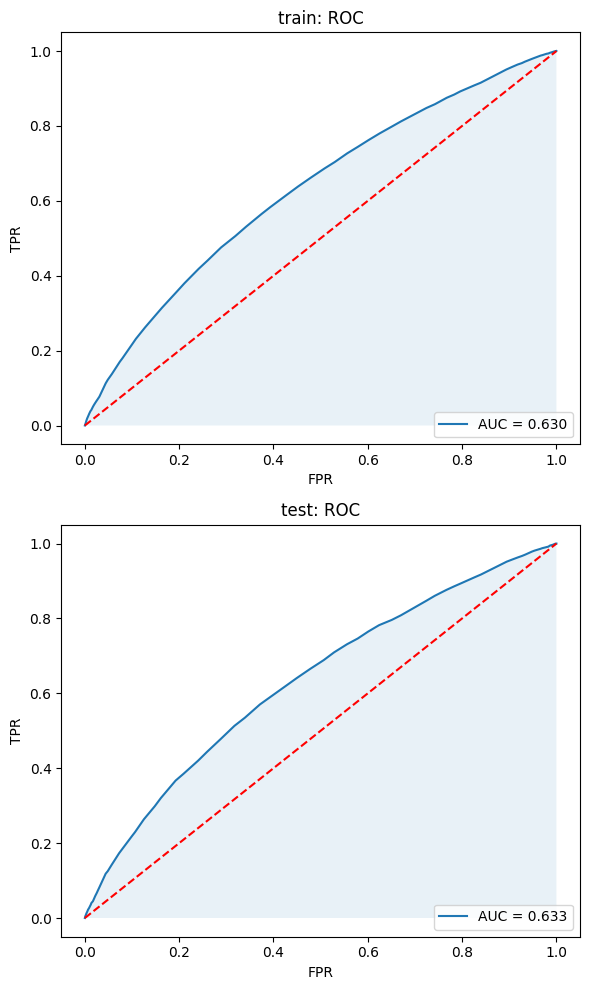

In [12]:
train_decision = -train_score['score']
test_decision  = -test_score['score']
train_decision = -train_score
test_decision  = -test_score

# --- Compute ROC and AUC for train ---
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, train_decision)
auc_train = metrics.roc_auc_score(y_train, train_decision)

# --- Compute ROC and AUC for test ---
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, test_decision)
auc_test = metrics.roc_auc_score(y_test, test_decision)

print(f"Train AUC: {auc_train:.3f}")
print(f"Test  AUC: {auc_test:.3f}")

# --- Plot ROC curves (train + test) ---
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# Train ROC
axes[0].plot(fpr_train, tpr_train, label=f"AUC = {auc_train:.3f}")
axes[0].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[0].set_title("train: ROC")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].fill_between(fpr_train, tpr_train, alpha=0.1)
axes[0].legend(loc="lower right")

# Test ROC
axes[1].plot(fpr_test, tpr_test, label=f"AUC = {auc_test:.3f}")
axes[1].plot([0, 1], [0, 1], 'r--')  # random baseline
axes[1].set_title("test: ROC")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].fill_between(fpr_test, tpr_test, alpha=0.1)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [13]:
# combine all variable tables into one big dataframe
card_df = pd.concat(card.values(), ignore_index=True)

# show all rows (or set a big number)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

card_df

,variable,bin,points
0,basepoints,NaN,0.0
1,NAME_INCOME_TYPE,"Businessman%,%Student%,%State servant",68.0
2,NAME_INCOME_TYPE,Pensioner,68.0
3,NAME_INCOME_TYPE,Commercial associate,67.0
4,NAME_INCOME_TYPE,"Working%,%Unemployed%,%Maternity leave",65.0
5,DEBT_RATIO,"[-inf,0.22)",67.0
6,DEBT_RATIO,"[0.22,inf)",58.0
7,OCCUPATION_TYPE,"Accountants%,%HR staff%,%Core staff",73.0
8,OCCUPATION_TYPE,"Secretaries%,%Managers%,%High skill tech staff%,%Medicine staff%,%Private service staff%,%MISSING%,%IT staff",70.0
9,OCCUPATION_TYPE,"Sales staff%,%Cooking staff%,%Realty agents%,%Cleaning staff%,%Laborers%,%Security staff%,%Waiters/barmen staff%,%Drivers%,%Low-skill Laborers",61.0


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [15]:
loan_amount = df['AMT_CREDIT']

In [16]:
df.columns

Index(['TARGET', 'DEBT_RATIO', 'AMT_ANNUITY', 'NAME_INCOME_TYPE', 'AMT_CREDIT',
       'AGE', 'OCCUPATION_TYPE', 'AMT_CREDIT_SUM_DEBT_sum', 'YEARS_EMPLOYED'],
      dtype='object')

In [17]:
# Define loss per defaulting loan (mean loan amount)
loss_per_defaulting_loan = df['AMT_CREDIT'].mean()  # Mean loan amount as loss for defaults

# Realistic assumptions for consumer loans
interest_rate = 0.1  # 10% annual interest rate
loan_term_years = 5  # Loan term in years (realistic for personal loans)

# Calculate monthly repayment based on the loan amount
monthly_interest_rate = interest_rate / 12
num_payments = loan_term_years * 12  # 5 years, monthly payments
loan_amount = df['AMT_CREDIT'].mean()

# Monthly payment calculation (Loan Amortization Formula)
monthly_payment = loan_amount * monthly_interest_rate / (1 - (1 + monthly_interest_rate) ** -num_payments)
total_repayment = monthly_payment * num_payments  # Total repayment over the loan term

# Profit from successful loan (total repayment minus the loan amount)
profit_per_successful_loan = total_repayment - loan_amount

print("Profit per Successful Loan:", profit_per_successful_loan)
print("Loss per Defaulting Loan:", loss_per_defaulting_loan)



Profit per Successful Loan: 173144.4666241191
Loss per Defaulting Loan: 630022.4746302456


Define the function that will calculate the profit and loss at different cutoff scores. The function uses the confusion matrix to identify the number of true positives, false positives, true negatives, and false negatives, and then calculates the profit and loss based on those values.

In [18]:
# Function to calculate profit and loss at different cutoff values
def calculate_profit(cutoff, scores, actuals, loan_amount):
    # Predicted labels based on cutoff score
    predicted_labels = (scores < cutoff).astype(int)
    
    # Confusion Matrix (TN, FP, FN, TP)
    cm = confusion_matrix(actuals, predicted_labels)
    TN, FP, FN, TP = cm.ravel()

    print("Number of Successful Loan: ", TP)
    print("Number of Failed Loan: ", FP)

    # Profit from successful loans (loans predicted to be "good" and actually good)
    successful_loans = TP  
    profit = successful_loans * profit_per_successful_loan

    print("profit: ", profit)


    
    
    # Loss from defaults (loans predicted to be "bad" but they were actually good (FP) or predicted and actually bad (TP))
    defaulting_loans = FP 
    loss = defaulting_loans * loss_per_defaulting_loan

    print("loss: ", loss)
    print("-----------")
    
    # Net Profit (Profit - Loss)
    net_profit = profit - loss 
    
    return net_profit


In [19]:
# Example cutoff values to test
cutoffs = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700]

# Empty list to store profits for each cutoff
profits = []

# Calculate profit for each cutoff
for cutoff in cutoffs:
    profit = calculate_profit(cutoff, test_score, y_test, loan_amount)
    profits.append(profit)


Number of Successful Loan:  0
Number of Failed Loan:  0
profit:  0.0
loss:  0.0
-----------
Number of Successful Loan:  0
Number of Failed Loan:  0
profit:  0.0
loss:  0.0
-----------
Number of Successful Loan:  0
Number of Failed Loan:  0
profit:  0.0
loss:  0.0
-----------
Number of Successful Loan:  0
Number of Failed Loan:  0
profit:  0.0
loss:  0.0
-----------
Number of Successful Loan:  155
Number of Failed Loan:  632
profit:  26837392.326738458
loss:  398174203.9663152
-----------
Number of Successful Loan:  2981
Number of Failed Loan:  22363
profit:  516143655.006499
loss:  14089192600.156181
-----------
Number of Successful Loan:  5617
Number of Failed Loan:  65360
profit:  972552469.0276769
loss:  41178268941.832855
-----------
Number of Successful Loan:  5809
Number of Failed Loan:  70499
profit:  1005796206.6195078
loss:  44415954438.95769
-----------
Number of Successful Loan:  5809
Number of Failed Loan:  70499
profit:  1005796206.6195078
loss:  44415954438.95769
--------

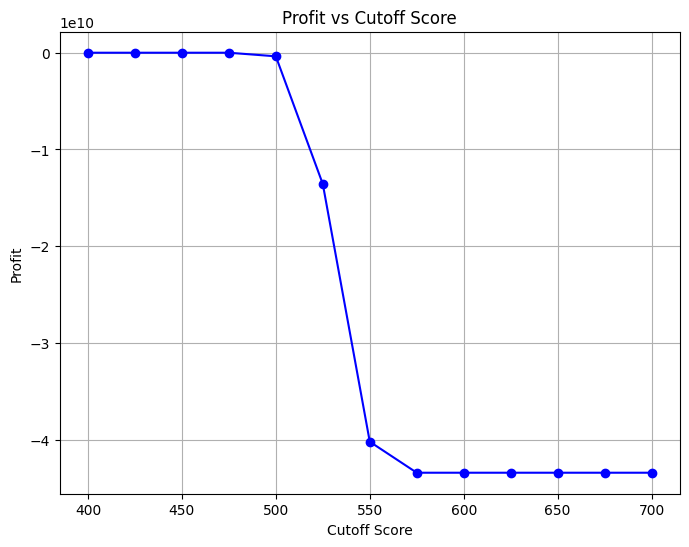

In [20]:
# Plotting the profit at different cutoff scores
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, profits, marker='o', linestyle='-', color='b')
plt.title("Profit vs Cutoff Score")
plt.xlabel("Cutoff Score")
plt.ylabel("Profit")
plt.grid(True)
plt.show()
